# Analyzing borrowers’ risk of defaulting

Your project is to prepare a report for a bank’s loan division. You’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

Your report will be considered when building a **credit scoring** of a potential customer. A ** credit scoring ** is used to evaluate the ability of a potential borrower to repay their loan.

## Open the data file and have a look at the general information. 

In [5]:
# File Opened:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/1. Full Projects/Practicum/Credit Scoring Statistical EDA/datasets/credit_scoring_eng.csv")

df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# File Examined
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [8]:
# Describe the numerical columns (skew, outliers)
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


In [9]:
# Printing the categorical column labels
for col in df.select_dtypes(include=['object']):
    print(str(col))
    print(df[col].unique())
    print()

education
["bachelor's degree" 'secondary education' 'Secondary Education'
 'SECONDARY EDUCATION' "BACHELOR'S DEGREE" 'some college'
 'primary education' "Bachelor's Degree" 'SOME COLLEGE' 'Some College'
 'PRIMARY EDUCATION' 'Primary Education' 'Graduate Degree'
 'GRADUATE DEGREE' 'graduate degree']

family_status
['married' 'civil partnership' 'widow / widower' 'divorced' 'unmarried']

gender
['F' 'M' 'XNA']

income_type
['employee' 'retiree' 'business' 'civil servant' 'unemployed'
 'entrepreneur' 'student' 'paternity / maternity leave']

purpose
['purchase of the house' 'car purchase' 'supplementary education'
 'to have a wedding' 'housing transactions' 'education' 'having a wedding'
 'purchase of the house for my family' 'buy real estate'
 'buy commercial real estate' 'buy residential real estate'
 'construction of own property' 'property' 'building a property'
 'buying a second-hand car' 'buying my own car'
 'transactions with commercial real estate' 'building a real estate'
 'hous

In [10]:
# Calculate the total missing data (%)
print('Total Missing Data (%)')
print(df.isna().sum() / len(df))

Total Missing Data (%)
children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64


### Conclusion

**Data Types**
- 2 ordinal discret numerical columns (Children, DOB Years)
- 2 ordinal continuous columns (days_employed, total_income)
- 6 nominal categorical columns (Purpose, Income Type, Family Status, Family Status ID, Education, Education ID)
- 2 Binary Columns (Gender, Debt)


**Expected Preprocessing**
- Text columns need preprocessing (str.lower, Gender has error value XNA, purpose column can be categorized)
- Numeric columns have outliers (days_employed, children, and potentially income) and negative values for days_employed and number of children
- A little over 10% missing data which affects both days_employed and total_income, investigate correlation

## Data preprocessing

### Categorizing Purpose Column

In [11]:
# Categorizing loan types
loan_types = ['wedding loan', 'car loan', 'mortgage', 'construction', 'education loan', 'renovation', 'real estate']
purpose = ['wedding', 'car', 'hous', 'building|construc', 'university|educat', 'home improvement', 'real estate|rent']

loan_cats = zip(purpose, loan_types)

for purpose, cat in loan_cats:
    df.loc[df['purpose'].str.contains(purpose), 'purpose'] = cat
    
df['purpose'].unique()

array(['mortgage', 'car loan', 'education loan', 'wedding loan',
       'real estate', 'construction', 'property'], dtype=object)

### Dealing with Corrupted and Duplicate Data

In [12]:
# As the impact of number of children on a customer defaulting is a task of this excersise I will drop the 20 children 
# also the sample size for 4, 5, 20 are likely too small to be able to say with certainty if those numbers have an effect
# Another option would be to convert to 2 which is likely a clerical error at the time of processing. 
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [13]:
# Formating education columns and removing XNA gender row 
df['education'] = df['education'].str.lower()
df.drop(df.index[df['gender'] == 'XNA'], inplace=True)
df.drop(df.index[df['children'] == 20], inplace=True)



# Lets also convert the negative days_employed and children to positive 
#(Note to communicate this error to the analyst who compiled the data)
# df[df['children'] < 0]
df['days_employed'] = abs(df['days_employed'])
df['children'] = abs(df['children'])

# Dropping duplicate rows
df[df.duplicated()]
df.drop_duplicates(inplace=True)

In [14]:
# Per df.describe investigating which income_type that the days_employeed outliers belong to
df[df['days_employed'] > 300000]['income_type'].unique()

array(['retiree', 'unemployed'], dtype=object)

In [15]:
# This data is corrupted and with just two instances we will drop it we cannot create an assumotion of day_employed or
# total_income (Note that while unemployement is a factor in credit score with a larger subset we should not drop / exclude as 
# there may be other factors such as savings, inheritance or passive income not labelled in this dataset
# df[df['income_type'] == 'unemployed']
df =  df[df['income_type'] != "unemployed"]

In [16]:
# As with unemployed all the retiree days_employed data is corrupted and with no data to establish a true figure
# for days_employeed we could chose to drop the data and ask the analyst team to recheck the data. However 
# for the excersise lets hypothisis that the every retiree worked the average number of days in their life prior to 
# retiring which per EU commision is 13140-days/36-years (F) - 13870-days/38-years(M)

# However after further review it appears that the days_employed for retirees may be incorrectly returned as hours 
# employed as when converted by hours the days_wemployed falls in expected range ~35 years. Lets proceed with this assumptions
df[(df['income_type'] == 'retiree') & (df['days_employed'] > 300000)].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,wedding loan
18,0,400281.136913,53,secondary education,1,widow / widower,2,F,retiree,0,9091.804,car loan
24,1,338551.952911,57,secondary education,1,unmarried,4,F,retiree,0,46487.558,real estate
25,0,363548.489348,67,secondary education,1,married,0,M,retiree,0,8818.041,real estate
30,1,335581.668515,62,secondary education,1,married,0,F,retiree,0,27432.971,real estate


In [18]:
df.loc[df.days_employed > 300000, 'days_employed'] = df.days_employed / 24
# Index 4 example
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,mortgage
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car loan
2,0,5623.422610,33,secondary education,1,married,0,M,employee,0,23341.752,mortgage
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,education loan
4,0,14177.753002,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,wedding loan


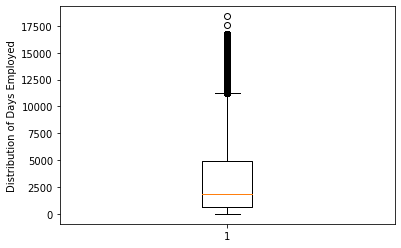

In [19]:
# Plotting distribution of modified days_employed
plt.boxplot(df['days_employed'].fillna(0))
plt.ylabel("Distribution of Days Employed")
plt.show()

### Dealing with Missing Values and Converting Data Types

In [20]:
# Confirming that the all missing values of days_employed are connected to 
# total_income and which income_type it belongs to
print(df.isna().sum() / len(df),"\n")
print("Perc Missing Data from days_employed and total_income:",round(len(df[df['days_employed'].isna() & (df['total_income'].isna())]) / len(df),6),"\n")
print(df[df['days_employed'].isna() & (df['total_income'].isna())]['income_type'].unique())

children            0.000000
days_employed       0.089875
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.089875
purpose             0.000000
dtype: float64 

Perc Missing Data from days_employed and total_income: 0.089875 

['retiree' 'civil servant' 'business' 'employee' 'entrepreneur']


Note 
- As days_employed and total_income are missing on the same rows one can assume that these customers are unemployed
- However they have filled the income_type column which begs the question is this a data error?
    - For this excerise to practice mapping syntax we will treat this as a data error and map averages to the NA values for both columns 

In [ ]:
# Creating averages with sample size count for days_employed and total_income based on two of the more
# important factors that influence employement income_type and education
df.groupby(["income_type", "education"])[['days_employed', 'total_income']].agg(['mean', 'count'])

days_employed        \
                                                         mean count   
income_type                 education                                 
business                    bachelor's degree     2020.923222  1595   
                            primary education     2019.310449    29   
                            secondary education   2242.943250  2674   
                            some college          1411.946136   259   
civil servant               bachelor's degree     3182.314561   488   
                            graduate degree       5968.075884     1   
                            primary education     3483.831436     6   
                            secondary education   3602.805230   770   
                            some college          2216.913600    46   
employee                    bachelor's degree     2266.549338  2099   
                            graduate degree       2704.223421     3   
                            primary education     1853.910264   133   
                            secondary education   2382.734710  7407   
                            some college          1594.035604   332   
entrepreneur                bachelor's degree      520.848083     1   
paternity / maternity leave secondary education   3296.759962     1   
retiree                     bachelor's degree    13505.000000   520   
                            graduate degree      13505.000000     2   
                            primary education    13505.000000    93   
                            secondary education  13505.000000  2786   
                            some college         13505.000000    35   
student                     bachelor's degree      578.751554     1   

                                                 total_income        
                                                         mean count  
income_type                 education                                
business                    bachelor's degree    38809.639078  1595  
                            primary education    26409.124931    29  
                            secondary education  28719.576637  2674  
                            some college         31659.769486   259  
civil servant               bachelor's degree    31571.287664   488  
                            graduate degree      17822.757000     1  
                            primary education    29449.016667     6  
                            secondary education  24627.216451   770  
                            some college         27596.312587    46  
employee                    bachelor's degree    30665.230281  2099  
                            graduate degree      31089.653667     3  
                            primary education    21954.056075   133  
                            secondary education  24411.222903  7407  
                            some college         27976.897726   332  
entrepreneur                bachelor's degree    79866.103000     1  
paternity / maternity leave secondary education   8612.661000     1  
retiree                     bachelor's degree    27306.878056   520  
                            graduate degree      28334.215000     2  
                            primary education    17810.387914    93  
                            secondary education  21074.247448  2786  
                            some college         22129.937314    35  
student                     bachelor's degree    15712.260000     1

In [ ]:
# Mapping the values from the double indexed groupby object to the NA values
df['total_income'] = df.groupby(["income_type", "education"])['total_income'].transform(lambda x: x.fillna(x.mean()))
df['days_employed'] = df.groupby(["income_type", "education"])['days_employed'].transform(lambda x: x.fillna(x.mean()))

# converting float columns to integer
df['days_employed'] = df['days_employed'].round().astype(int)
df['total_income'] = df['total_income'].round().astype(int)

In [ ]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

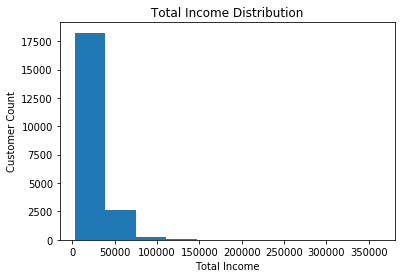

In [ ]:
plt.hist(df['total_income'])
plt.xlabel("Total Income")
plt.ylabel("Customer Count")
plt.title("Total Income Distribution");

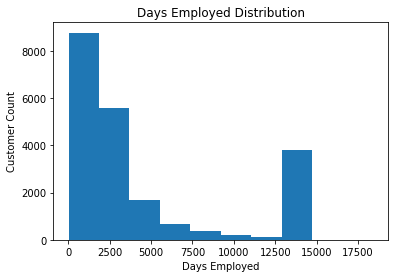

In [ ]:
plt.hist(df['days_employed'])
plt.xlabel("Days Employed")
plt.ylabel("Customer Count")
plt.title("Days Employed Distribution");

### Conclusion

- What was the principle of data categorization
    - In order to group various loan pruposes into more defined categories 
- Which missing values you identified
    - total_income and day_employed where missing just over 10% and missing values 
- Possible reasons these missing values were present
    - Potentially they are unemployed but as the income_type was filled I will assume that it was an error in the initial data processing for this excercise
- Which method you used to fill in missing values
    - Created total_income averages using goupby of income_type and eduction and mapped them using lambda function 
- Which method you used to find and delete duplicate data and why
    - df.duplicated for find 100% row duplicates and drop_duplicates to drop
- Possible reasons why duplicate data was present
    -  A second loan application by customer or as always data wrangling error
- Which method you used to change the data type and why
    - .round().astype(int) to change floats to int to round up days_worked and total_income as a form of standardization
- Which dictionaries you've selected for this dataset and why
    - Unclear what this means? which libraries? Pandas, Matplotlib, Seaborn, Scipy

## Answer these questions

### Is there a relation between number of children and loan defaulting

In [ ]:
# Importing scipy stats package for T-test, ANOVA, Chi Squared tests as supplimentary to data visualiozation
from scipy import stats

# One-Way Anova On the Effect Size Of Children on Loan Default Rate
groups = df['children'].unique()
group_vals = []
textstr = 'Sample Sizes:\n'+str(df['children'].value_counts())[:-28]+'\n'
textstr += "Children Effect Size on Loan Defaulting (ANOVA):\n"

for g in groups:
    group_vals.append(df[df['children'] == g]['debt'])
    f, p = stats.f_oneway(*group_vals)

textstr += f"F-stat: {f.round(3)} p=value:{p.round(3)}\n"    
print(textstr)

Sample Sizes:
0    13934
1     4828
2     2044
3      329
4       41
5        9

Children Effect Size on Loan Defaulting (ANOVA):
F-stat: 3.613 p=value:0.003



/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3347: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn


In [ ]:
# Students T-test To Isolate the count of children which has the greatest effect size on loan defaulting
from scipy import stats

groups = df['children'].unique()
ttests = []


for i, g in enumerate(groups):
    for i2, g2 in enumerate(groups):
        if i2 > i:
            group1 = df[df['children']==g]['debt']
            group2 = df[df['children']==g2]['debt']

            t, p = stats.ttest_ind(group1, group2)

            ttests.append([g, g2, t.round(3), p.round(3)])

p_threshold = 0.5 /len(ttests)
textstr += f"\nBonferroni Adj. p-value: {round(p_threshold, 3)}\n"

for pair in ttests:
    if pair[-1] <= p_threshold:
        textstr += f"Number of Children: {pair[0]}-{pair[1]} | T-stat: {pair[2]} | p-value: {pair[3]}\n"

print(textstr)

Sample Sizes:
0    13934
1     4828
2     2044
3      329
4       41
5        9

Children Effect Size on Loan Defaulting (ANOVA):
F-stat: 3.613 p=value:0.003

Bonferroni Adj. p-value: 0.033
Number of Children: 1-0 | T-stat: 3.471 | p-value: 0.001
Number of Children: 0-2 | T-stat: -2.934 | p-value: 0.003



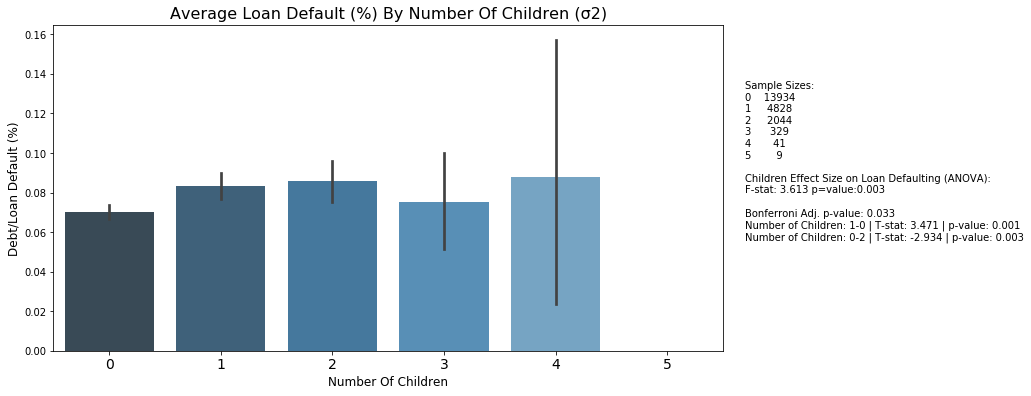

In [ ]:
# Visualization of impact of children on loan defaulting
import seaborn as sns
import numpy as np
viz = sns.barplot('children', 'debt', data=df, estimator=np.var, palette="Blues_d", order=[0, 1, 2, 3, 4, 5])
viz.figure.set_size_inches(12, 6)
viz.set_xticklabels(viz.get_xticklabels(), fontsize=14)
viz.set_xlabel("Number Of Children", fontsize=12)
viz.set_ylabel("Debt/Loan Default (%)", fontsize=12)
viz.set_title("Average Loan Default (%) By Number Of Children (σ2)", fontsize=16)
plt.text(5.7,0.05, textstr);

#### Conclusion
- The most significant effect of children on customers defaulting on loans is between 0-2 children with a 3-4% higher likelyhood to default
- 0-4 children also has an effect, however, the sample size is too small to draw a conclusion and the p-value falls above the threshold
- Also all customers with 5 children have not defaulted on their loans, however, again the sample size is too small to draw conclusions

### Is there a relation between marital status and repaying a loan on time?

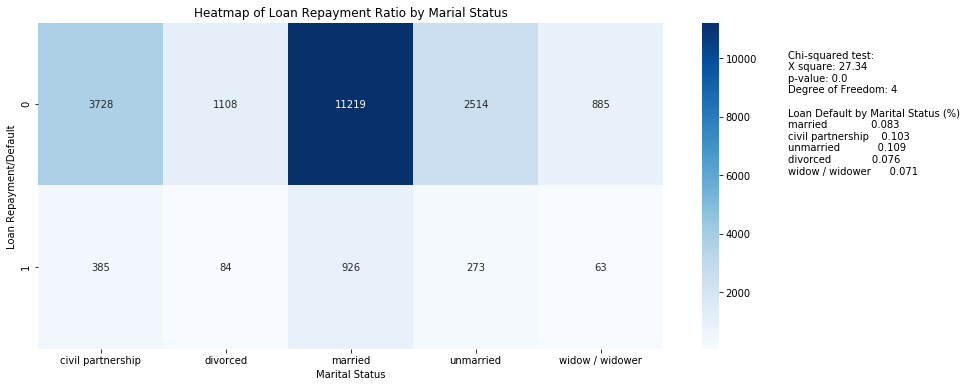

In [ ]:
# Crosstab for heat map and chi squared contingency 
crosstab = pd.crosstab(df['debt'], df['family_status'])

X, p , dof, contingency_table = stats.chi2_contingency(crosstab)
good = df[df['debt'] == 0]['family_status'].value_counts()
bad = df[df['debt'] == 1]['family_status'].value_counts()

default_perc = str(round(bad / good,3))

textstr = f"Chi-squared test:\nX square: {X.round(3)}\np-value: {p.round(3)}\nDegree of Freedom: {dof}\n\nLoan Default by Marital Status (%)\n{default_perc[:-35]}"


plt.figure(figsize=(14,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='Blues')
plt.title("Heatmap of Loan Repayment Ratio by Marial Status")
plt.xlabel('Marital Status')
plt.ylabel('Loan Repayment/Default')
plt.text(6, 1, textstr);

#### Conclusion
- The data is imbalanced towards Married Couples who are middling among the categories in terms of defaulting
- Civil Partnerships and Unmarried Couples seem to default at a higher rate ~10%
- Divorced and widowers have lower likelihood to default

### Is there a relation between income level and repaying a loan on time?

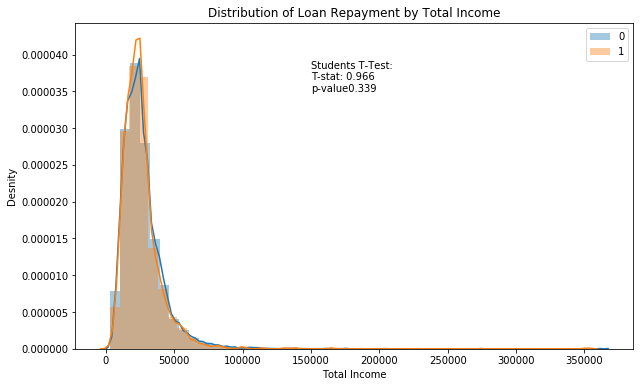

In [ ]:
# T-test for effect size of total income of loan defaulting
groups = df['debt'].unique()

for g in groups:
    t, p = stats.ttest_ind(group1, group2)

textstr2 = f"Students T-Test:\nT-stat: {t.round(3)}\np-value{p.round(3)}"


plt.figure(figsize=(10,6))
for g in groups:
    sns.distplot(df[df['debt'] == g]['total_income'])

plt.legend(groups)
plt.text(150000, 0.000035, textstr2)
plt.title("Distribution of Loan Repayment by Total Income")
plt.ylabel('Desnity')
plt.xlabel('Total Income')
plt.show()

#### Conclusion
- Very slight correlation between income level and loan repayment with marginally higher density of lower income < $50000 in debt

### How do different loan purposes affect on-time repayment of the loan?

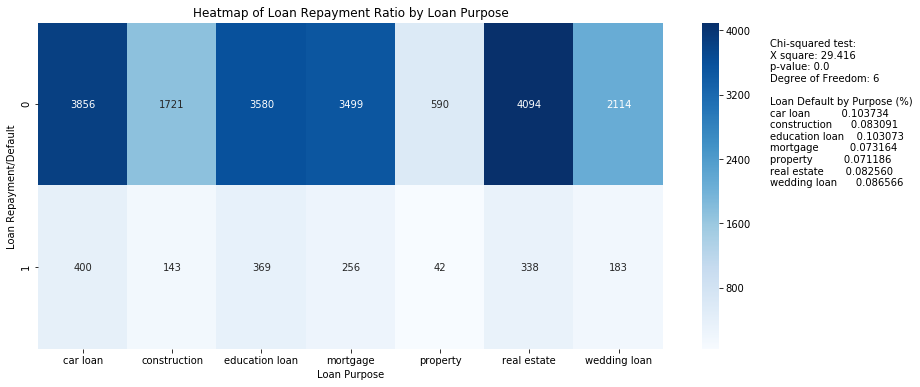

In [ ]:
# Crosstab for heat map and chi squared contingency 
crosstab = pd.crosstab(df['debt'], df['purpose'])

X, p , dof, contingency_table = stats.chi2_contingency(crosstab)

good = df[df['debt'] == 0]['purpose'].value_counts()
bad = df[df['debt'] == 1]['purpose'].value_counts()

default_perc = str(bad / good)

textstr = f"Chi-squared test:\nX square: {X.round(3)}\np-value: {p.round(3)}\nDegree of Freedom: {dof}\n\nLoan Default by Purpose (%)\n{default_perc[:-30]}"

plt.figure(figsize=(14,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='Blues')
plt.title("Heatmap of Loan Repayment Ratio by Loan Purpose")
plt.ylabel('Loan Repayment/Default')
plt.xlabel("Loan Purpose")
plt.text(8.2, 1, textstr);

#### Conclusion
- Car and Education loans are 2-3% more likely to be default than other categories

## General conclusion

**Things to consult with the person or persons who compiled this data**
- What caused the negative values for days_worked
- Are the rows with missing values in days_employed and total_income dependant or independant of the income_type category
- Why is there a consistent over-representation error with retiree's and unemployed days_worked
    - days employed for retirees seems to be incorrectly returned as hours employed as when converted by hours the days_employed falls in expected range ~14500hr which = ~35 years
- is the counts of customers with 20 children a clerical error at the time of processing and is supposed to be 2

**Features with the most signifigant effect on loan repayment**
- Customers with 1 or 2 children are 3-4% moire likely to default on loan repayments - a p-value below the Bonferonni adj score giving a certainty that this score represent the population mean
- Civil partnerships and Unmaried Couples are 3-4% more likely to default on loan repayments than other marital status - again a low p-value giving a certainty that this score represent the population mean
- Total Income has only a slight effect size on loan repayments - p-value of 0.339
- Car and Education loans are 2-3% more likely to be default than other categories - again a low p-value giving a certainty that this score represent the population mean

## Project Readiness Checklist


- [x]  file open;
- [x]  file examined;
- [x]  missing values defined;
- [x]  missing values are filled;
- [x]  an explanation of which missing value types were detected;
- [x]  explanation for the possible causes of missing values;
- [x]  an explanation of how the blanks are filled;
- [x]  replaced the real data type with an integer;
- [x]  an explanation of which method is used to change the data type and why;
- [x]  duplicates deleted;
- [x]  an explanation of which method is used to find and remove duplicates;
- [x]  description of the possible reasons for the appearance of duplicates in the data;
- [x]  data is categorized;
- [x]  an explanation of the principle of data categorization;
- [x]  an answer to the question "Is there a relation between having kids and repaying a loan on time?";
- [x]  an answer to the question " Is there a relation between marital status and repaying a loan on time?";
- [x]   an answer to the question " Is there a relation between income level and repaying a loan on time?";
- [x]  an answer to the question " How do different loan purposes affect on-time repayment of the loan?"
- [x]  conclusions are present on each stage;
- [x]  a general conclusion is made.